## Бонусное ДЗ №4 Нейросетевое моделирование следующей корзины

#### В этой домашке вам предстоит реализовать нейросеть, которая моделирует паттерны повторных покупок людей

#### Дата выдачи: 11.06.25

#### Жесткий дедлайн: 18.06.25 23:59 MSK

## Описание задания

В этом задании вам предстоит реализовать нейронную сеть для моделирования поведения пользователей в доменах с высокой частотой повторяющихся взаимодействий между пользователями и товарами (айтемами).

### Структура задания

Задание состоит из трёх основных блоков:

1. **Подготовка данных и базовый подход (макс 3 балла)**
   - Подготовка датасета для экспериментов
   - Реализация простого базового решения (TopPersonal) для последующего сравнения

2. **Реализация нейронной сети BasketHSERec (макс 4 балла)**
   - Реализация архитектуры, моделирующей динамику взаимодействий пользователя с каждым конкретным товаром
   - Учёт временных закономерностей в истории покупок

3. **Эксперименты и анализ (макс 3 балла)**
   - Проведение сравнительных экспериментов между предложенной моделью и базовым подходом
   - Анализ результатов и формулирование выводов

<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/latest.js?config=TeX-AMS-MML_HTMLorMML"></script>

In [1]:
# Все необходимые импорты
from collections import Counter, defaultdict
import random
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import binary_cross_entropy_with_logits
from IPython.display import clear_output
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

### 1. Подготовка данных (1 балл)


In [2]:
df = pd.read_parquet('https://drive.google.com/uc?export=download&id=1IiDGfEUNcefnrD_0hLWvvyYeCoATUADf')
df.head()

,user_id,day,item_id
0,2375,1,1004906
1,2375,1,1033142
2,2375,1,1036325
3,2375,1,1082185
4,2375,1,8160430


In [3]:
# Небольшой анализ
print("Всего записей:", len(df))
print("Уникальных пользователей:", df['user_id'].nunique())
print("Уникальных товаров:", df['item_id'].nunique())
print("Пропусков:\n\n", df.isna().sum())
print("Полных дубликатов: ", df.duplicated().sum())

Всего записей: 2595732
Уникальных пользователей: 2500
Уникальных товаров: 92339
Пропусков:

 user_id    0
day        0
item_id    0
dtype: int64
Полных дубликатов:  7927


In [4]:
# Группировка транзакций по пользователю и дню - формирование корзин
baskets_df = df.groupby(['user_id', 'day'])['item_id'].apply(list).reset_index()
baskets_df.sort_values(['user_id', 'day'], inplace=True)
baskets_df

,user_id,day,item_id
0,1,51,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,1,67,"[852662, 856942, 997025, 1030547, 1049998, 105..."
2,1,88,"[841266, 865178, 953561, 991024, 995242, 99590..."
3,1,94,"[827656, 831447, 845896, 852662, 856942, 85754..."
4,1,101,"[852662, 856942, 887375, 909472, 922417, 93113..."
...,...,...,...
225528,2500,695,"[835616, 844179, 879988, 895617, 903233, 91970..."
225529,2500,698,"[883847, 920200, 962717, 6391068, 8118676, 130..."
225530,2500,704,"[823721, 828278, 834382, 838319, 859427, 86434..."
225531,2500,706,"[874116, 1036403, 1130581, 6534196, 9880241, 1..."


In [5]:
# Группировка по пользователям - сбор списков корзин
user_baskets = baskets_df.groupby('user_id')['item_id'].apply(list)
user_baskets

,item_id
user_id,
1,"[[825123, 831447, 840361, 845307, 852014, 8549..."
2,"[[854852, 930118, 1077555, 1098066, 5567388, 5..."
3,"[[866211, 878996, 882830, 904360, 921345, 9319..."
4,"[[836163, 857849, 877523, 878909, 883932, 8914..."
5,"[[938983, 5980822], [1012352], [825538, 100249..."
...,...
2496,"[[840361, 852159, 871756, 886703, 899624, 9161..."
2497,"[[838220, 1037840, 1052294, 5569230, 8090537],..."
2498,"[[824555, 835576, 901776, 904023, 911215, 9174..."


In [6]:
# Разбиение на train/test по схеме leave-one-basket
## Подготовка списков кортежей (user_id, исторические товары, товары корзины трейна/теста для предсказаний)
train_data = []
test_data = []

## Оставляем только пользователей с ≥3 корзинами
user_baskets = user_baskets[user_baskets.apply(len) >= 3]

# Фильтрация товаров
item_counts = defaultdict(int)
for baskets in user_baskets:
    for basket in baskets:
        for item in set(basket):
            item_counts[item] += 1

frequent_items = set([item for item, count in item_counts.items() if count >= 5])

def filter_basket(basket):
    return [item for item in basket if item in frequent_items]

user_baskets = user_baskets.apply(lambda baskets: [filter_basket(basket) for basket in baskets])
user_baskets = user_baskets[user_baskets.apply(lambda baskets: all(len(b) > 0 for b in baskets))]

In [7]:
## Сбор датасетов
for user, baskets in user_baskets.items():
    *history_baskets, test_basket = baskets
    history_items_all = [item for basket in history_baskets for item in basket]
    test_data.append((user, history_items_all, test_basket))
    if len(history_baskets) > 0:
        for t in range(1, len(history_baskets)):
            target_basket = history_baskets[t]
            context_baskets = history_baskets[:t]
            context_items = [item for basket in context_baskets for item in basket]
            train_data.append((user, context_items, target_basket))

print("Датасет train:", len(train_data))
print("Датасет test:", len(test_data))

Датасет train: 110871
Датасет test: 1494


> На трейне модель будет обучаться по истории пользовательских корзин, а тест будет использоваться для сверки предсказания последней пользовательской корзины (поэтому на тесте содержатся данные по одной корзине на пользователя)

Далее, так как планируется реализацией нейросетевой модели на Pytorch, необходимо сделать кодировку идентификаторов пользователей и товаров целочисленными индексами - надо создать словари отображения id-шников в индексы и применить их к данным

In [8]:
unique_users = list(user_baskets.index)
user2idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
unique_items = sorted({item for baskets in user_baskets for basket in baskets for item in basket})
item2idx = {item_id: idx for idx, item_id in enumerate(unique_items)}
n_users = len(user2idx)
n_items = len(item2idx)

train_data_idx = []
for user, context_items, target_items in train_data:
    user_idx = user2idx[user]
    context_idx = [item2idx[it] for it in context_items]
    target_idx = [item2idx[it] for it in target_items]
    train_data_idx.append((user_idx, context_idx, target_idx))

test_data_idx = []
for user, context_items, target_items in test_data:
    user_idx = user2idx[user]
    context_idx = [item2idx[it] for it in context_items]
    target_idx = [item2idx[it] for it in target_items]
    test_data_idx.append((user_idx, context_idx, target_idx))

In [9]:
train_data_idx[0]

(0,
 [2674, 8016, 18342, 19792, 22952, 22970, 23046, 23121, 27626],
 [2089, 11377])

> Данные готовы, идем обучать

### 2. Реализация TopPersonal (2 балла)


In [11]:
# Создание класса реализации модели TopPersonal

class TopPersonal():
    def __init__(self, train_data: List, test_data: List):
        self.train = train_data
        self.test = test_data

    def create_top_k_recs(self, K):
        # Частота покупок по юзерам
        self.K = K
        user_freq = {}
        for user_idx, context_items, target_items in self.train:
            freq = Counter(context_items)
            if user_idx in user_freq:
                user_freq[user_idx].update(freq)
            else:
                user_freq[user_idx] = freq

        # Создание Top@K по юзерам
        top_k_recs = {}
        for user_idx, freq_counter in user_freq.items():
            sorted_items = [item for item, count in freq_counter.most_common()]
            top_k_recs[user_idx] = sorted_items[:self.K]

        return top_k_recs

    def calculate_recall_and_ndcg_at_K(self, top_k_recs):
        recall_list = []
        ndcg_list = []
        for user_idx, context_items, true_items in self.test:
            if user_idx not in top_k_recs:
                continue
            rec_items = top_k_recs[user_idx]
            true_set = set(true_items)
            hits = sum(1 for item in rec_items if item in true_set)
            recall = hits / len(true_set)
            recall_list.append(recall)

            dcg = 0.0
            for rank, item in enumerate(rec_items, start=1):
                if item in true_set:
                    dcg += 1.0 / np.log2(rank + 1)
            ideal_hits = min(len(true_set), self.K)
            idcg = sum(1.0 / np.log2(r + 1) for r in range(1, ideal_hits + 1))
            ndcg = dcg / idcg if idcg > 0 else 0.0
            ndcg_list.append(ndcg)

        return np.mean(recall_list), np.mean(ndcg_list)

In [12]:
# Инициализация модели
toppersonal = TopPersonal(train_data=train_data_idx, test_data=test_data_idx)

In [13]:
# Составление рекомендаций модели
k = 3
topk_recs = toppersonal.create_top_k_recs(K=k)

# Подсчет метрик
print(f'TopPersonal Recall@{k}: {toppersonal.calculate_recall_and_ndcg_at_K(topk_recs)[0]}')
print(f'TopPersonal NDCG@{k}: {toppersonal.calculate_recall_and_ndcg_at_K(topk_recs)[1]}')

TopPersonal Recall@3: 0.0669668105161448
TopPersonal NDCG@3: 0.19322938651487753


In [14]:
# Составление рекомендаций модели
k = 10
topk_recs = toppersonal.create_top_k_recs(K=k)

# Подсчет метрик
print(f'TopPersonal Recall@{k}: {toppersonal.calculate_recall_and_ndcg_at_K(topk_recs)[0]}')
print(f'TopPersonal NDCG@{k}: {toppersonal.calculate_recall_and_ndcg_at_K(topk_recs)[1]}')

TopPersonal Recall@10: 0.11768952820755782
TopPersonal NDCG@10: 0.1643925874590335


> Результаты, очевидно, не самые лучшие, модель плохо предсказывает следующие корзины пользователей. Однако это не значит что модель плохая, ведь метрики можно расшифровать как "даю 1 к 10 что этот товар он точно возьмет" и это не удивительно — в рекомендациях с высокой повторяемостью покупок действительно сильный «повторяющийся» эффект (пользователи могут иметь свойство брать повторяющиеся товары)

### 3. Обучение BasketHSERec (2 балла)


Архитектура модели BasketHSERec


1. Входные данные:
- история покупок пользователя (список товаров из предыдущих корзин);
- кандидат-товар, для которого нужно предсказать вероятность покупки.

2. Представление истории:
- Каждому товару сопоставляется обучаемый эмбеддинг фиксированной размерности;
- Эмбеддинги всех товаров из истории суммируются;
- Получается агрегированный вектор истории пользователя `h_u`, отражающий его предпочтения (часто покупаемые товары имеют больший вклад).

3. Эмбеддинги пользователя и товара

4. Функция скоринга $f(h_u, e_i)$:
для оценки релевантности товара $i$ пользователю $u$ формируется вектор контекста $c_u$:
   - $h_u$ (если `mode='history'`);
   - $u_emb$ (если `mode='embed'`);
   - $[u_emb ; h_u]$ (если `mode='both'`).

  Контекст и товарный эмбеддинг пропускаются через отдельные линейные слои. Полученные представления складываются, затем применяется ReLU и Dropout. Скалярный логит получается через скалярное произведение скрытого вектора на обучаемый вектор $w_out$ и добавление bias.

5. Обучение модели
- Формулируется задача многоклассовой бинарной классификации (multi-label BCE);
- Для каждого примера модель предсказывает логиты для всех товаров;
- Используется функция потерь `BCEWithLogitsLoss`;
- Модель обучается батчами через `DataLoader`;
- После каждой эпохи рассчитывается средний `loss` и визуализируется график обучения;
- После обучения модель оценивается на тестовой выборке по метрикам `Recall@K` и `NDCG@K`.

6. Регуляризация
- Применяется `Dropout` после ReLU;
- Используется `weight_decay` (L2-регуляризация) в оптимизаторе `Adam`;
- Возможна настройка веса положительных примеров (`pos_weight`).

> Создание класса модели и других вспомогательных функций для обучения и оценки модели

In [10]:
class BasketHSERec(nn.Module):
    def __init__(self, num_users, num_items, embed_dim=64, hidden_dim=64, mode='both', dropout=0.3):
        """
        mode: 'both' - использовать и историю, и эмбеддинг пользователя;
              'history' - использовать только историю (игнорировать статический эмбеддинг пользователя);
              'embed' - использовать только эмбеддинги (статический вектор пользователя), игнорируя историю.
        """
        super(BasketHSERec, self).__init__()
        self.mode = mode
        self.user_embed = nn.Embedding(num_users, embed_dim)
        self.item_embed = nn.Embedding(num_items, embed_dim)
        nn.init.xavier_uniform_(self.user_embed.weight)
        nn.init.xavier_uniform_(self.item_embed.weight)
        input_context_dim = embed_dim * (2 if mode == 'both' else 1)
        self.W_context = nn.Linear(input_context_dim, hidden_dim)
        self.W_item = nn.Linear(embed_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.w_out = nn.Parameter(torch.randn(hidden_dim))
        self.b_out = nn.Parameter(torch.zeros(1))

    def forward(self, user_idx, context_idx_flat, context_lengths):
        """
        user_idx: тензор размеров (B,) с индексами пользователей в батче
        context_idx_flat: тензор с индексами товаров по всем контекстам батча (сплюснутый список)
        context_lengths: тензор (B,) с количеством товаров в истории для каждого пользователя в батче
        """
        batch_size = user_idx.shape[0]
        device = user_idx.device

        if self.mode != 'embed':
            item_emb_flat = self.item_embed(context_idx_flat)
            context_embeds_split = torch.split(item_emb_flat, context_lengths.tolist())
            context_vecs = [embeds.sum(dim=0) if embeds.shape[0] > 0
                            else torch.zeros(self.item_embed.embedding_dim, device=device)
                            for embeds in context_embeds_split]
            context_vecs = torch.stack(context_vecs, dim=0)
        else:
            context_vecs = torch.zeros((batch_size, self.item_embed.embedding_dim), device=device)

        if self.mode != 'history':
            user_vecs = self.user_embed(user_idx)
        else:
            user_vecs = torch.zeros((batch_size, self.user_embed.embedding_dim), device=device)

        context_input = (torch.cat([user_vecs, context_vecs], dim=1)
                         if self.mode == 'both' else user_vecs if self.mode == 'embed' else context_vecs)

        h_context = self.W_context(context_input)
        h_items = self.W_item(self.item_embed.weight)

        hidden_pre = h_context.unsqueeze(1) + h_items.unsqueeze(0)
        hidden = F.relu(hidden_pre)
        hidden = self.dropout(hidden)
        output = torch.tensordot(hidden, self.w_out, dims=([2], [0])) + self.b_out
        return output

class BasketDataset(torch.utils.data.Dataset):
    def __init__(self, data_list):
        self.data = data_list
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    batch_size = len(batch)
    users = [item[0] for item in batch]
    user_idx_batch = torch.tensor(users, dtype=torch.long)
    context_all = []
    context_lengths = []
    for _, context_items, _ in batch:
        context_all.extend(context_items)
        context_lengths.append(len(context_items))
    context_idx_flat = torch.tensor(context_all, dtype=torch.long)
    context_lengths = torch.tensor(context_lengths, dtype=torch.long)
    targets = torch.zeros((batch_size, n_items), dtype=torch.float)
    for i, (_, _, target_items) in enumerate(batch):
        for it in target_items:
            targets[i, it] = 1.0
    return user_idx_batch, context_idx_flat, context_lengths, targets

def plot_losses(train_losses, val_losses=None):
    clear_output(wait=True)
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    if val_losses is not None:
        plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy Loss")
    plt.title("Loss over Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()


def evaluate_model(model, test_data_idx, k_list=[3, 10], device=('cuda' if torch.cuda.is_available() else 'cpu')):
    model.eval()
    ndcg_scores = {k: [] for k in k_list}
    recall_scores = {k: [] for k in k_list}

    with torch.no_grad():
        for user_idx, context_items, true_items in test_data_idx:
            user_tensor = torch.tensor([user_idx], dtype=torch.long).to(device)
            context_tensor = torch.tensor(context_items, dtype=torch.long).to(device)
            context_len = torch.tensor([len(context_items)], dtype=torch.long).to(device)

            logits = model(user_tensor, context_tensor, context_len)
            probs = torch.sigmoid(logits).squeeze(0).cpu().numpy()
            true_set = set(true_items)

            for k in k_list:
                top_k_pred = np.argsort(probs)[::-1][:k]
                top_k_set = set(top_k_pred)

                hits = len(top_k_set & true_set)
                recall = hits / len(true_set)
                recall_scores[k].append(recall)

                dcg = sum(1.0 / np.log2(i+2) for i, item in enumerate(top_k_pred) if item in true_set)
                ideal_dcg = sum(1.0 / np.log2(i+2) for i in range(min(len(true_set), k)))
                ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0.0
                ndcg_scores[k].append(ndcg)

    results = {}
    for k in k_list:
        results[f'Recall@{k}'] = np.mean(recall_scores[k])
        results[f'NDCG@{k}'] = np.mean(ndcg_scores[k])
    return results

def collate_fn_neg_sample(batch, num_neg=10):
    batch_size = len(batch)
    users = [item[0] for item in batch]
    user_idx_batch = torch.tensor(users, dtype=torch.long)
    context_all = []
    context_lengths = []
    pos_items = []
    neg_items = []
    for _, context_items, target_items in batch:
        context_all.extend(context_items)
        context_lengths.append(len(context_items))
        pos_items.append(list(target_items))
        user_neg = []
        while len(user_neg) < num_neg:
            neg = random.randint(0, n_items - 1)
            if neg not in target_items:
                user_neg.append(neg)
        neg_items.append(user_neg)
    context_idx_flat = torch.tensor(context_all, dtype=torch.long)
    context_lengths = torch.tensor(context_lengths, dtype=torch.long)
    sampled_items = [p + n for p, n in zip(pos_items, neg_items)]
    sampled_labels = [ [1]*len(p) + [0]*len(n) for p, n in zip(pos_items, neg_items)]
    return user_idx_batch, context_idx_flat, context_lengths, sampled_items, sampled_labels

> Теперь перейдем к пайплайну обучения

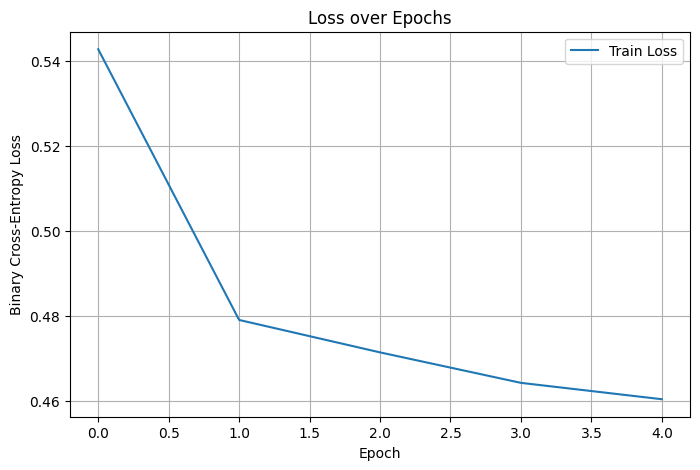

In [18]:
# Подготовка DataLoader для train_data
train_dataset = BasketDataset(train_data_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda b: collate_fn_neg_sample(b, num_neg=10))

# Инициализация модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BasketHSERec(n_users, n_items, embed_dim=64, hidden_dim=64, mode='both')
model = model.to(device)

# Оптимизатор и функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

# Обучение
num_epochs = 5
model.train()
train_losses = []
epoch_bar = tqdm(range(1, num_epochs + 1), desc="Обучение", leave=True)
for epoch in epoch_bar:
    total_loss = 0.0
    for user_batch, context_flat, context_len, sampled_items, sampled_labels in train_loader:
        user_batch = user_batch.to(device)
        context_flat = context_flat.to(device)
        context_len = context_len.to(device)
        loss = 0.0
        optimizer.zero_grad()
        offsets = np.cumsum([0] + context_len.tolist())
        for b in range(user_batch.shape[0]):
            user = user_batch[b:b+1]
            start = offsets[b]
            end = offsets[b+1]
            user_context = context_flat[start:end]
            user_context_len = context_len[b:b+1]
            items = torch.tensor(sampled_items[b], dtype=torch.long, device=device)
            labels = torch.tensor(sampled_labels[b], dtype=torch.float, device=device)
            logits = model(user, user_context, user_context_len).squeeze(0)[items]
            loss += binary_cross_entropy_with_logits(logits, labels)
        loss = loss / user_batch.shape[0]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    plot_losses(train_losses)

In [19]:
result_data = evaluate_model(model, test_data_idx, device=device)

In [20]:
pd.DataFrame.from_dict([result_data])

,Recall@3,NDCG@3,Recall@10,NDCG@10
0,0.051977,0.107918,0.07599,0.094417


In [12]:
# Сохранение весов
torch.save(model.state_dict(), "basket_hserec_weights.pth")

# Загрузка весов, если надо
## Создаём новую модель с такой же архитектурой
model = BasketHSERec(num_users=n_users, num_items=n_items, embed_dim=64, hidden_dim=64, mode='both')

## Загружаем сохранённые веса
model.load_state_dict(torch.load("basket_hserec_weights.pth"))

## Переводим модель в нужное устройство и режим
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.eval()

BasketHSERec(
  (user_embed): Embedding(1494, 64)
  (item_embed): Embedding(35977, 64)
  (W_context): Linear(in_features=128, out_features=64, bias=True)
  (W_item): Linear(in_features=64, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

### 4. Сравнение с TopPersonal (3 балла)

Сравнительная таблица:

| Модель            | NDCG@3   | Recall@3 | NDCG@10   | Recall@10 |
| :---------------- | :------: | :------: | :------: | -------: |
| TopPersonal       | 0.193 | 0.067 | 0.164 | 0.117 |
| BasketHSERec      | 0.107 | 0.052 | 0.094 | 0.076|

TopPersonal показал более высокие метрики, чем BasketHSERec. Возможная причина - TopPersonal использует прямую частотную информацию по каждому пользователю, что работает особенно эффективно при наличии повтора в поведении пользователей, что, возможно, можно наблюдать в данном датасете.

BasketHSERec в текущей реализации обучается на всем множестве товаров с сильным дисбалансом между позитивными и негативными примерами. Это приводит к размыванию признаков и слабому качеству предсказаний, особенно на метриках ранжирования.

Таким образом, TopPersonal выигрывает за счёт простоты, прямолинейной связи с пользовательской историей и отсутствия необходимости обучаться на шумных отрицательных примерах. BasketHSERec пока не раскрыл свой потенциал.


### 5. Анализ архитектурных решений (2 балла)

In [13]:
# Сделаем функцию обучения для упрощения эксперимента
# Если загружали модель из файла и не запускали ячейку с обучением, то нужно заново определить переменные тренировочного датасета
train_dataset = BasketDataset(train_data_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda b: collate_fn_neg_sample(b, num_neg=10))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(train_loader, mode: str, num_epochs=5, device=('cuda' if torch.cuda.is_available() else 'cpu')):
    model = BasketHSERec(n_users, n_items, embed_dim=64, hidden_dim=64, mode=mode).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        for user_batch, context_flat, context_len, sampled_items, sampled_labels in train_loader:
            user_batch = user_batch.to(device)
            context_flat = context_flat.to(device)
            context_len = context_len.to(device)
            loss = 0.0
            optimizer.zero_grad()
            offsets = np.cumsum([0] + context_len.tolist())
            for b in range(user_batch.shape[0]):
                user = user_batch[b:b+1]
                start = offsets[b]
                end = offsets[b+1]
                user_context = context_flat[start:end]
                user_context_len = context_len[b:b+1]
                items = torch.tensor(sampled_items[b], dtype=torch.long, device=device)
                labels = torch.tensor(sampled_labels[b], dtype=torch.float, device=device)
                logits = model(user, user_context, user_context_len).squeeze(0)[items]
                loss += F.binary_cross_entropy_with_logits(logits, labels)
            loss = loss / user_batch.shape[0]
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"[{mode}] Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")
    return model

In [14]:
# BasketHSERec: History + Embeddings
results_table = []
model_both = train_model(train_loader, mode='both', num_epochs=5, device=device)
results_both = evaluate_model(model_both, test_data_idx, device=device)
results_table.append({'Model': 'BasketHSERec (both)', **results_both})

# BasketHSERec: Только Embeddings
model_embed = train_model(train_loader, mode='embed', num_epochs=5, device=device)
results_embed = evaluate_model(model_embed, test_data_idx, device=device)
results_table.append({'Model': 'BasketHSERec (only embeddings)', **results_embed})

# BasketHSERec: Только History
model_hist = train_model(train_loader, mode='history', num_epochs=5, device=device)
results_hist = evaluate_model(model_hist, test_data_idx, device=device)
results_table.append({'Model': 'BasketHSERec (only history)', **results_hist})

results_table

[both] Epoch 1/5 | Loss: 0.5421
[both] Epoch 2/5 | Loss: 0.4765
[both] Epoch 3/5 | Loss: 0.4677
[both] Epoch 4/5 | Loss: 0.4634
[both] Epoch 5/5 | Loss: 0.4576
[embed] Epoch 1/5 | Loss: 0.4700
[embed] Epoch 2/5 | Loss: 0.4385
[embed] Epoch 3/5 | Loss: 0.4258
[embed] Epoch 4/5 | Loss: 0.4174
[embed] Epoch 5/5 | Loss: 0.4115
[history] Epoch 1/5 | Loss: 0.5683
[history] Epoch 2/5 | Loss: 0.4823
[history] Epoch 3/5 | Loss: 0.4731
[history] Epoch 4/5 | Loss: 0.4668
[history] Epoch 5/5 | Loss: 0.4612


[{'Model': 'BasketHSERec (both)',
  'Recall@3': np.float64(0.046752925178963574),
  'NDCG@3': np.float64(0.09268937118227663),
  'Recall@10': np.float64(0.07518295913375692),
  'NDCG@10': np.float64(0.0918704543303922)},
 {'Model': 'BasketHSERec (only embeddings)',
  'Recall@3': np.float64(0.05014964966028519),
  'NDCG@3': np.float64(0.10600463179201074),
  'Recall@10': np.float64(0.07876940486724267),
  'NDCG@10': np.float64(0.09775639414806017)},
 {'Model': 'BasketHSERec (only history)',
  'Recall@3': np.float64(0.04756574233644411),
  'NDCG@3': np.float64(0.09985261483688264),
  'Recall@10': np.float64(0.07668273415421298),
  'NDCG@10': np.float64(0.09574838688791584)}]

In [15]:
# Результаты
df_results = pd.DataFrame(results_table)
df_results

,Model,Recall@3,NDCG@3,Recall@10,NDCG@10
0,BasketHSERec (both),0.046753,0.092689,0.075183,0.091870
1,BasketHSERec (only embeddings),0.050150,0.106005,0.078769,0.097756
2,BasketHSERec (only history),0.047566,0.099853,0.076683,0.095748


### Сравнение результатов эксперимента:

| Вариант               | NDCG@3 | Recall@3 | NDCG@10 | Recall@10 |
|:-----------------------|:--------:|:----------:|:---------:|-----------:|
| a) History + Embeddings | 0.093       | 0.047         |  0.092       |  0.075         |
| b) Только Embeddings    |  0.106      |   0.05       |    0.098     |   0.079        |
| c) Только History       |   0.1     |    0.048      |    0.096     |   0.077        |
| TopPersonal (baseline)  | 0.193 | 0.067 | 0.164 | 0.117 |


#### Выводы:
- Эмбеддинги работают лучше, чем History.
- История тоже полезна, но добавление её к эмбеддингам не даёт прироста.
- Комбинация history + embeddings даёт худший результат — признаки дублируются.
- TopPersonal остаётся сильнейшим, что говорит о высоком уровне повторяемости покупок в датасете.

**Причины плохих показателей у BasketHSERec:**
1.	Дублирование сигналов
История и пользовательские эмбеддинги несут во многом схожую информацию, поэтому их объединение может приводить к переобучению.
2.	TopPersonal выигрывает, потому что он прямо отражает пользовательские частоты, без обучения и усложнения — и почему то именно этого достаточно в задаче с высокой повторяемостью корзин.


Итог: модель BasketHSERec не извлекает максимум из объединения признаков, а в задаче с повторяющимися пользовательскими корзинами выигрывает больше модель TopPersonal.
